# Is knowledge-transfer actually working?

Objectives:

- (1) Train on UMICH data, and directly predict AFIT
- (2) Train on AFIT only, and predict AFIT

Keep in mind, we are using ONLY the aggregated features to alleviate differing sample space.

**If the above two give bad results, we should be fairly confident that fine-tuning works.**

---

## Data Prep (AFIT and UMICH)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from warnings import filterwarnings

filterwarnings('ignore')

In [2]:
umich = pd.read_csv('../data/umich.csv',index_col=0)
afit = pd.read_csv('../data/afit.csv',index_col=0)

In [3]:
runs = umich['Run'].unique()
variables = {}

# Loop through a range of values
for i in runs:
    # Create a new variable name
    variable_name = f"{i}"
    
    # Create a new variable value
    variable_value = umich[umich['Run']==i]
    
    # Assign the variable value to the variable name in the dictionary
    variables[variable_name] = variable_value.reset_index(drop=True)

for variable_name, variable_value in variables.items():
    globals()[variable_name] = variable_value
    
df_list = [R0, R1, R2, R3, R4, R5, R6, R7, R8, R9, R10, R11,
           R12, R13, R14, R15, R17, R18, R19, R20, R21,
           R22, R23, R24, R25, R26, R27, R28, R29, R30, R31,
           R32, R33, R34, R35, R36, R37] # Note: R16 is dropped because of NaN values.

pressure_transducers = ['p1','p2','p3','p4','p5']
location_list = ['px1','px2','px3','px4','px5']

In [4]:
train_run_umich = ['R0','R8','R2','R12','R32','R24','R36','R14','R33',
                   'R28','R29','R30','R31','R37','R21','R6','R9','R10',
                   'R11','R23','R35','R27','R13','R15','R20','R1','R3','R4','R5','R7','R17','R18','R19','R22','R25','R26']

test_run_umich = ['R11','R23','R35','R27','R13','R15','R20','R1','R3','R4','R5','R7','R17','R18','R19','R22','R25','R26']

In [87]:
def aggregate_features(df):
    """Given a dataframe, the function will return X, y, and the original dataframe with its aggregated features"""
    df = df.copy()
    original_columns = df.columns
    
    df['mean_press'] = df[['p1','p2','p3','p4','p5']].mean(axis=1)
    df['median_press'] = df[['p1','p2','p3','p4','p5']].median(axis=1)
    df['std_press'] = df[['p1','p2','p3','p4','p5']].std(axis=1)
    df['var_press'] = df[['p1','p2','p3','p4','p5']].var(axis=1)
    df['max_press'] = df[['p1','p2','p3','p4','p5']].max(axis=1)
    df['min_press'] = df[['p1','p2','p3','p4','p5']].min(axis=1)
    #df['rolling_mean_press'] = df['mean_press'].rolling(300).mean()
    #df['rolling_median_press'] = df['mean_press'].rolling(300).mean()
    #df['rolling_std_press'] = df['mean_press'].rolling(300).std()

    
    #Original feature (first and last transducers)
    #df['p1_rolled_mean']=df['p1'].rolling(300).mean()
    #df['p5_rolled_mean'] = df['p5'].rolling(300).mean()
    #df['p1_rolled_median']=df['p1'].rolling(300).median()
    #df['p5_rolled_median'] = df['p5'].rolling(300).median()
    #df['p1_rolled_std']=df['p1'].rolling(300).std()
    #df['p5_rolled_std'] = df['p5'].rolling(300).std()
    #df['p1_'] = df['p1']
    #df['p1_mean'] = df['p1'].mean()
    #df['p1_median'] = df['p1'].median()
    #df['p1_std'] = df['p1'].std()
    #df['p5_'] = df['p5']
    #df['p5_mean'] = df['p5'].mean()
    #df['p5_median'] = df['p5'].median()
    #df['p5_std'] = df['p5'].std()

    y = df['x1']
    X = df.drop(original_columns,axis=1)
    return X, y, df

---

# Training the umich data

In [88]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import load_model

In [89]:
X,y,df = aggregate_features(umich)

In [90]:
X['Run'] = df['Run']
X['x1'] = y

In [91]:
train_set = X[X['Run'].isin(train_run_umich)]
test_set = X[X['Run'].isin(test_run_umich)]
df_train = df[df['Run'].isin(train_run_umich)]
df_test = df[df['Run'].isin(test_run_umich)]

In [92]:
def RunNeuralNet(train_df, test_df):
    X_train = train_df.drop(['x1','Run'],axis=1)
    X_test = test_df.drop(['x1','Run'],axis=1)
    y_train = train_df['x1']
    y_test = test_df['x1']

    ss = StandardScaler()

    X_train_scaled = ss.fit_transform(X_train)
    X_test_scaled = ss.transform(X_test)
    
    model = Sequential()
    model.add(Dense(20, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(10, activation='relu'))

    model.add(Dense(1))

    model.compile(optimizer='adam',loss='mse')
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)
    
    model.fit(x=X_train_scaled,y=y_train.values,
          validation_data=(X_test_scaled,y_test.values),
          batch_size=128,epochs=100,callbacks=[early_stopping])
    
    y_pred = model.predict(X_test_scaled)
    test_df = test_df.copy()
    test_df['pred'] = y_pred
    
    return test_df,model,ss

In [93]:
result, model,ss = RunNeuralNet(train_set, test_set)

Epoch 1/100
8754/8754 [==============================] - 5s 581us/step - loss: 9171.3164 - val_loss: 104.7949
Epoch 2/100
8754/8754 [==============================] - 5s 515us/step - loss: 90.9286 - val_loss: 77.2044
Epoch 3/100
8754/8754 [==============================] - 4s 506us/step - loss: 80.5903 - val_loss: 73.7996
Epoch 4/100
8754/8754 [==============================] - 4s 507us/step - loss: 66.2660 - val_loss: 52.1216
Epoch 5/100
8754/8754 [==============================] - 4s 505us/step - loss: 53.6499 - val_loss: 45.7724
Epoch 6/100
8754/8754 [==============================] - 4s 505us/step - loss: 46.9667 - val_loss: 44.2905
Epoch 7/100
8754/8754 [==============================] - 5s 528us/step - loss: 44.0585 - val_loss: 36.8644
Epoch 8/100
8754/8754 [==============================] - 4s 510us/step - loss: 42.5287 - val_loss: 35.1663
Epoch 9/100
8754/8754 [==============================] - 4s 511us/step - loss: 41.4715 - val_loss: 34.1533
Epoch 10/100
8754/8754 [==========

In [94]:
result['time'] = df_test['time']

In [95]:
df_test['Run'] = result['Run']

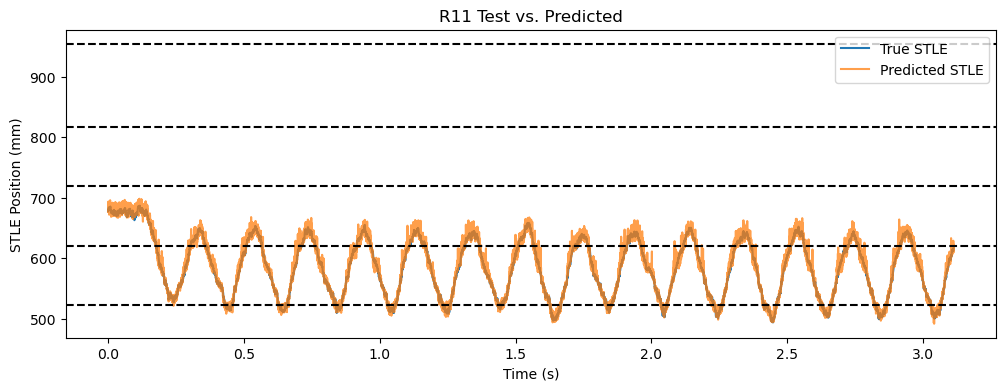

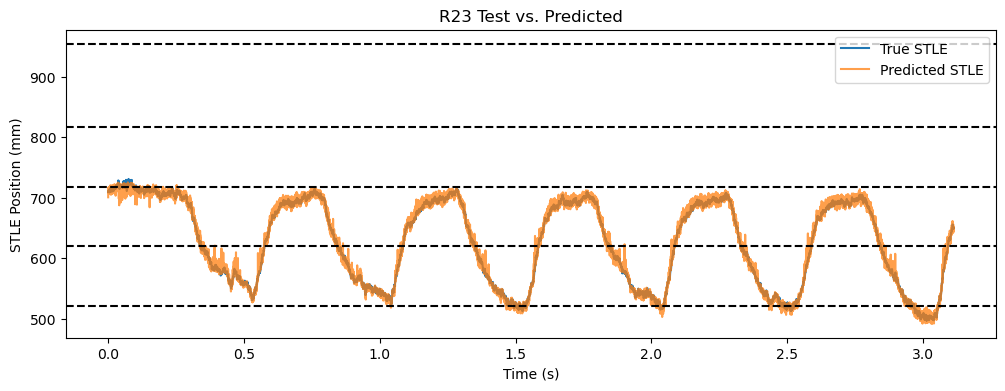

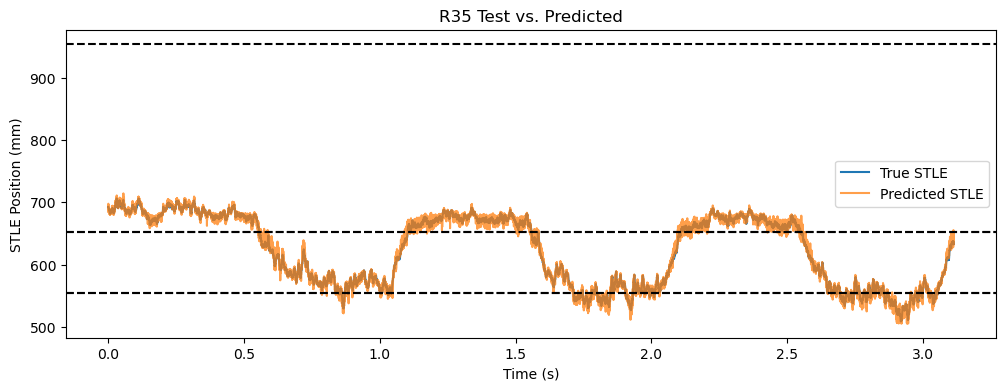

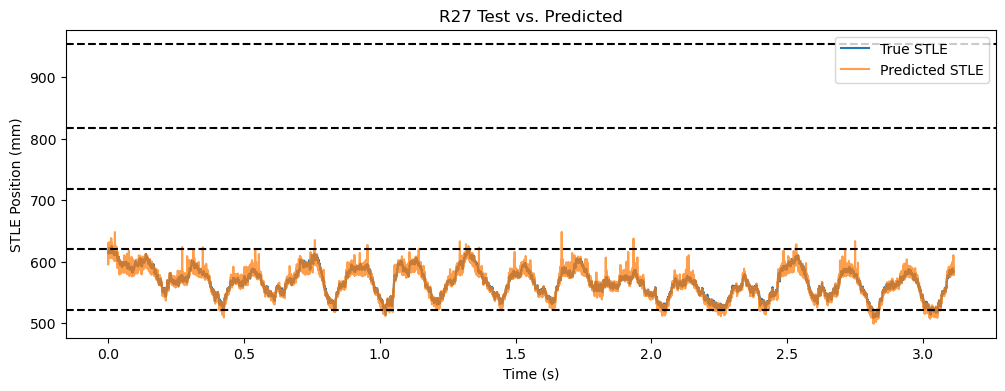

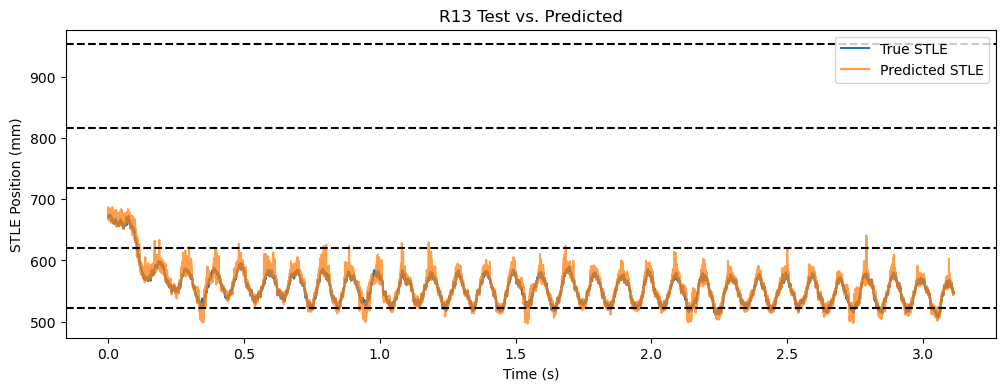

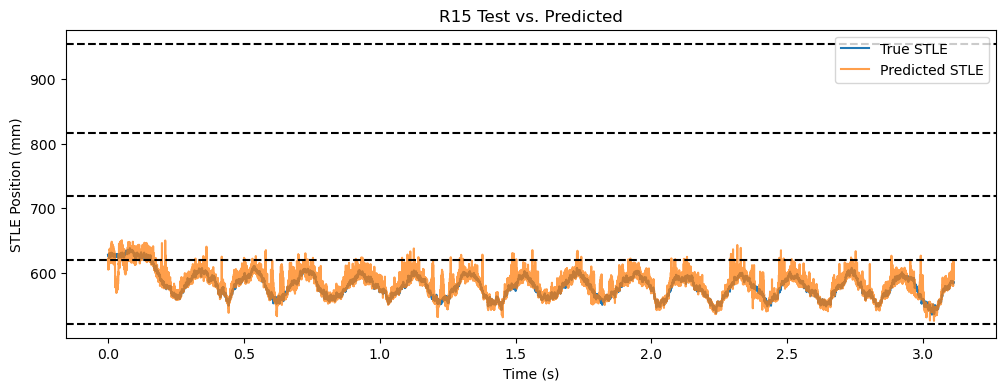

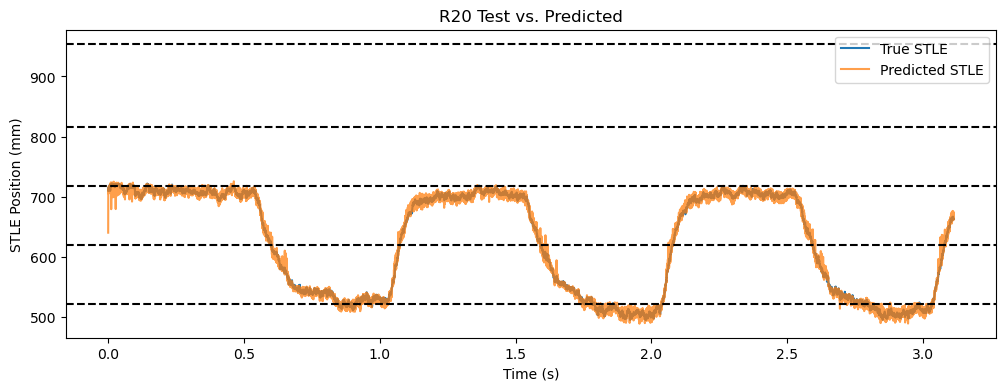

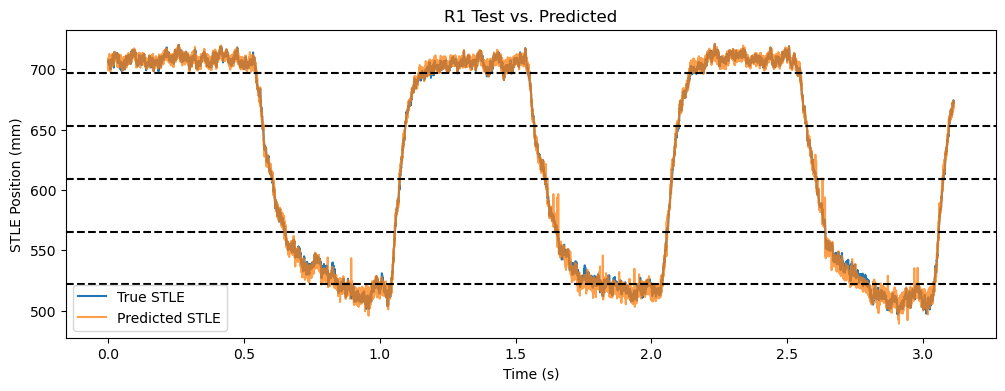

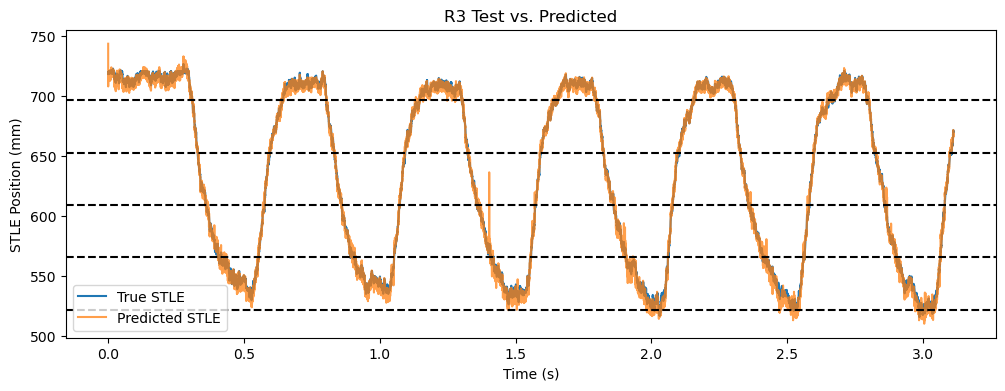

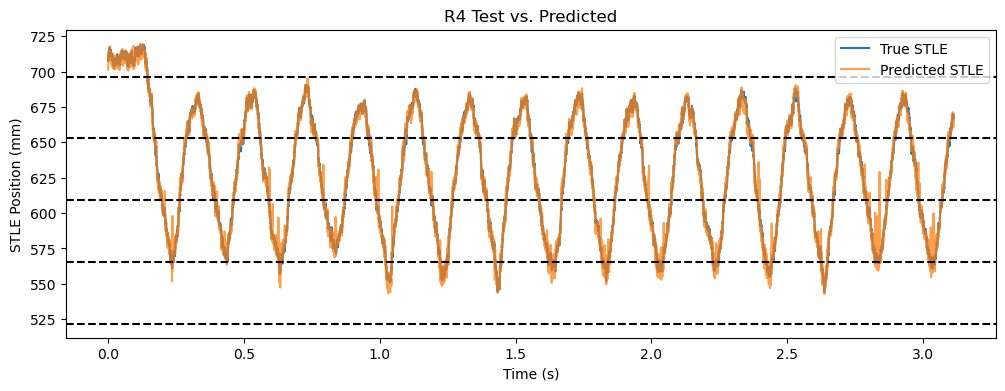

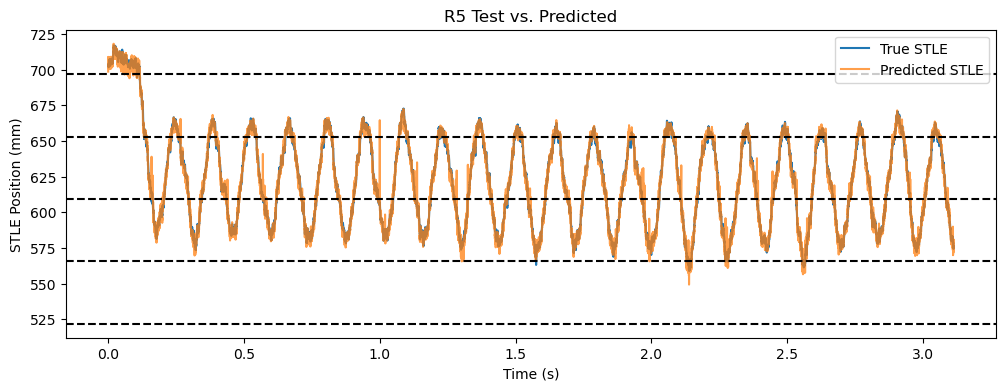

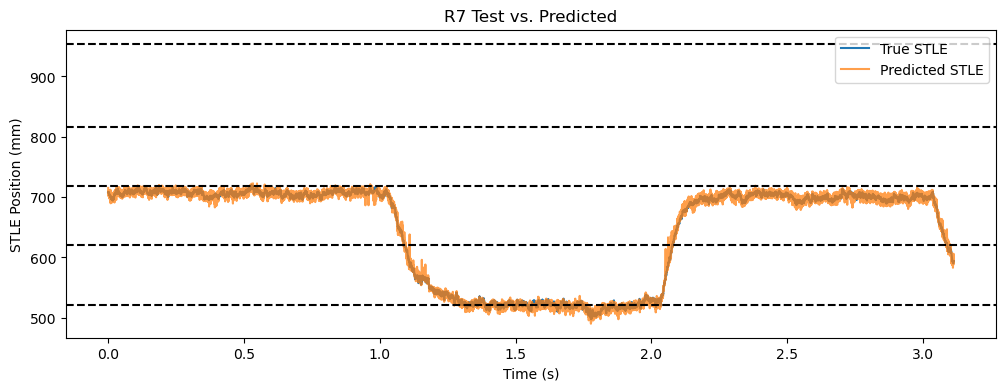

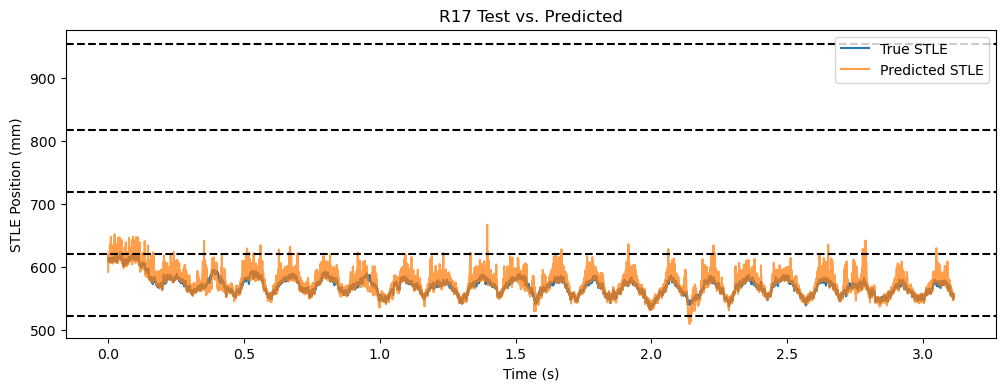

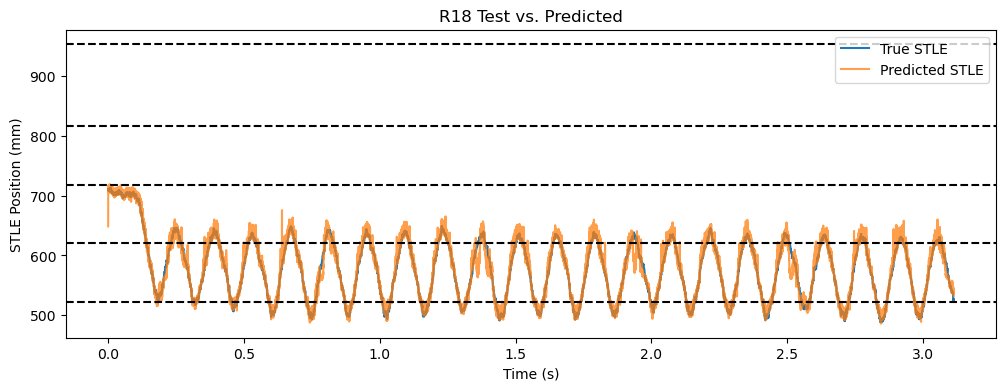

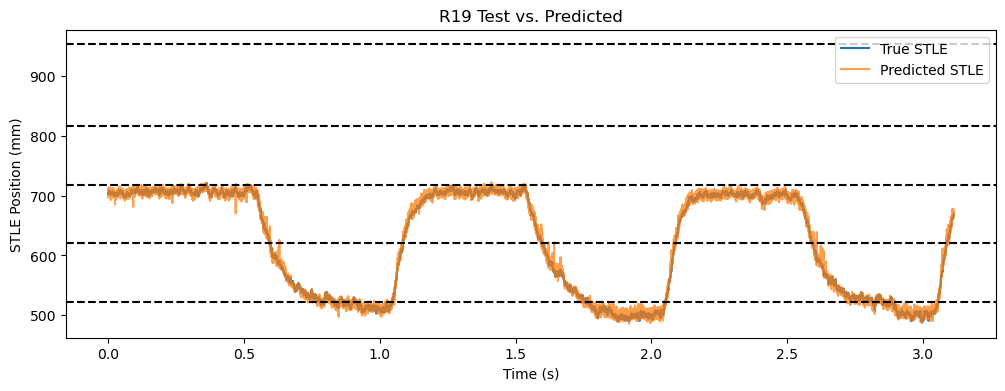

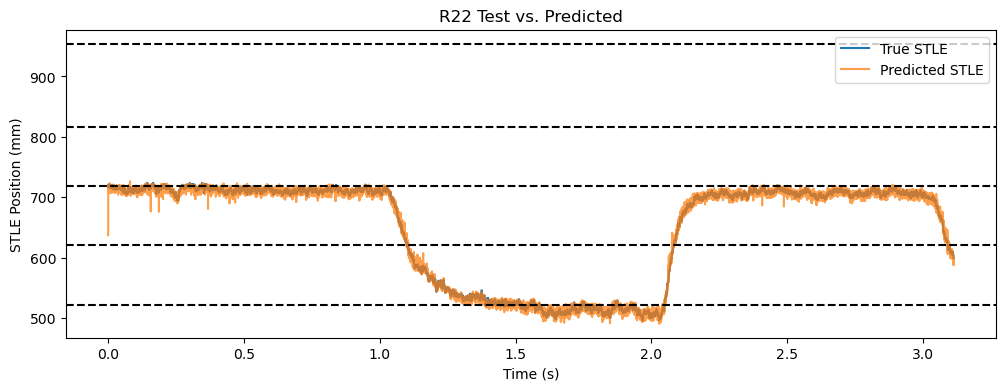

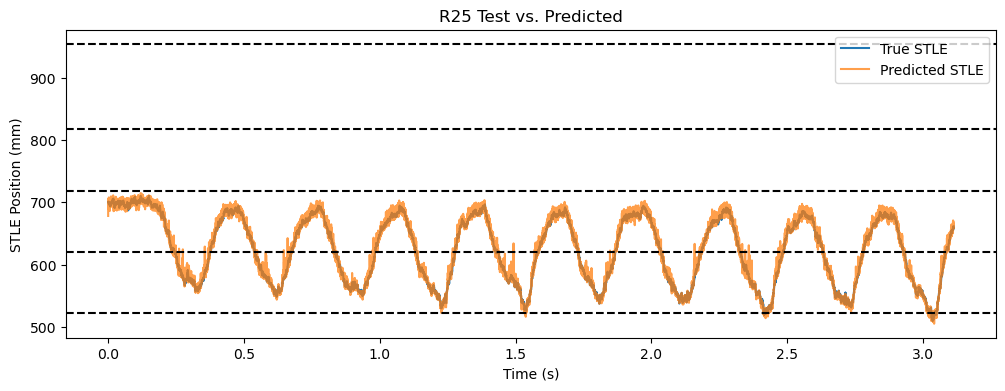

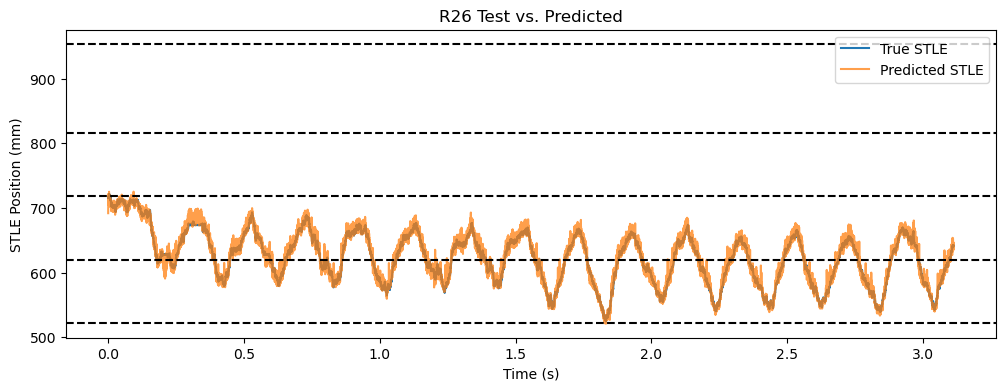

In [96]:
for i in test_run_umich:
    result_subset = result[result['Run'] == i]
    plt.figure(figsize=(12,4))
    plt.plot(result_subset['time'], result_subset['x1'],label='True STLE')
    plt.plot(result_subset['time'], result_subset['pred'],label='Predicted STLE',alpha=0.75)
    plt.xlabel('Time (s)')
    plt.ylabel('STLE Position (mm)')
    plt.legend()
    for j in location_list:
        plt.axhline(y=df_test[df_test['Run']==i][j].iloc[0], color='black', linestyle='--')
        
    plt.title(f"{i}" + ' Test vs. Predicted')
    plt.show()

In [97]:
model.save('no_time_aggregated_model_umich_use_for_transfer_learning_jul5')

INFO:tensorflow:Assets written to: no_time_aggregated_model_umich_use_for_transfer_learning_jul5/assets


INFO:tensorflow:Assets written to: no_time_aggregated_model_umich_use_for_transfer_learning_jul5/assets


---

## With the built model, directly apply to AFIT dataset

In [109]:
def aggregate_features_afit(df,window_size=300):
    df = df.copy()
    original_columns = df.columns    
    df['mean_press'] = df[['p1','p2','p3','p4','p5','p6','p7','p8','p9','p10','p11','p12','p13','p14']].mean(axis=1)
    df['median_press'] =  df[['p1','p2','p3','p4','p5','p6','p7','p8','p9','p10','p11','p12','p13','p14']].median(axis=1)
    df['std_press'] =  df[['p1','p2','p3','p4','p5','p6','p7','p8','p9','p10','p11','p12','p13','p14']].std(axis=1)
    df['var_press'] =  df[['p1','p2','p3','p4','p5','p6','p7','p8','p9','p10','p11','p12','p13','p14']].var(axis=1)
    df['max_press'] =  df[['p1','p2','p3','p4','p5','p6','p7','p8','p9','p10','p11','p12','p13','p14']].max(axis=1)
    df['min_press'] =  df[['p1','p2','p3','p4','p5','p6','p7','p8','p9','p10','p11','p12','p13','p14']].min(axis=1)
    
    
    #df['rolling_mean_press'] = df['mean_press'].rolling(window_size).mean()
    #df['rolling_median_press'] = df['mean_press'].rolling(window_size).mean()
    #df['rolling_std_press'] = df['mean_press'].rolling(window_size).std()

    
    #Original feature (first and last transducers)
    #df['p1_rolled_mean']=df['p7'].rolling(window_size).mean()
    #df['p5_rolled_mean'] = df['p11'].rolling(window_size).mean()
    #df['p1_rolled_median']=df['p7'].rolling(window_size).median()
    #df['p5_rolled_median'] = df['p11'].rolling(window_size).median()
    #df['p1_rolled_std']=df['p7'].rolling(window_size).std()
    #df['p5_rolled_std'] = df['p11'].rolling(window_size).std()
    #df['p1_'] = df['p7']
    #df['p1_mean'] = df['p7'].mean()
    #df['p1_median'] = df['p7'].median()
    #df['p1_std'] = df['p7'].std()
    #df['p14_'] = df['p11']
    #df['p14_mean'] = df['p11'].mean()
    #df['p14_median'] = df['p11'].median()
    #df['p14_std'] = df['p11'].std()

    y = df['x1']
    X = df.drop(original_columns,axis=1)
    return X, y, df

In [21]:
X_afit,y_afit,afit_df = aggregate_features_afit(afit)

X_afit['Run'] = afit_df['Run']
X_afit['x1'] = y_afit

train_run_afit = ['R8']
test_run_afit = ['R6','R7']

train_set_afit = X_afit[X_afit['Run'].isin(train_run_afit)]
test_set_afit = X_afit[X_afit['Run'].isin(test_run_afit)]
df_train_afit = afit_df[afit_df['Run'].isin(train_run_afit)]
df_test_afit = afit_df[afit_df['Run'].isin(test_run_afit)]

train_set_afit['H'] = 63.5
train_set_afit['W'] = 63.5
test_set_afit['H'] = 63.5
test_set_afit['W'] = 63.5

X_train_afit = train_set_afit.drop(['Run','x1','H','W'],axis=1)
X_test_afit = test_set_afit.drop(['Run','x1','H','W'],axis=1)
y_train_afit = train_set_afit['x1']
y_test_afit = test_set_afit['x1']

In [22]:
y_pred_afit = model.predict(X_test_afit)

409/409 [==============================] - 0s 261us/step


In [23]:
test_set_afit['pred'] = y_pred_afit.flatten()

In [24]:
test_set_afit[['px1','px2','px3','px4','px5']] = df_test_afit[['px1','px2','px3','px4','px5']]

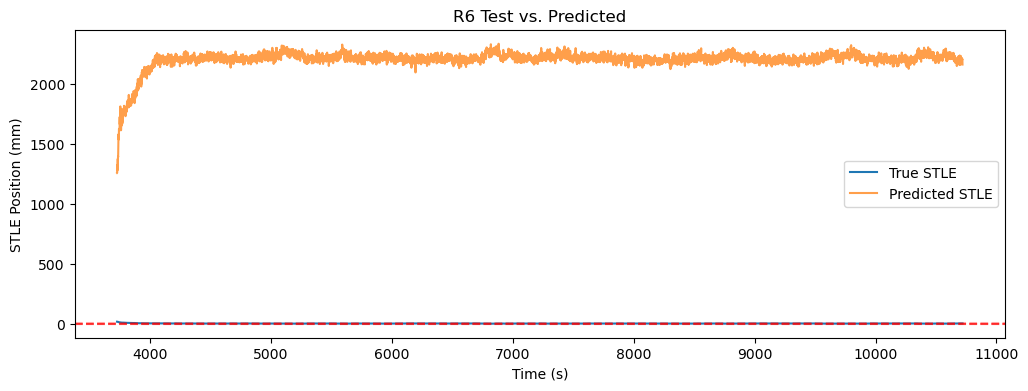

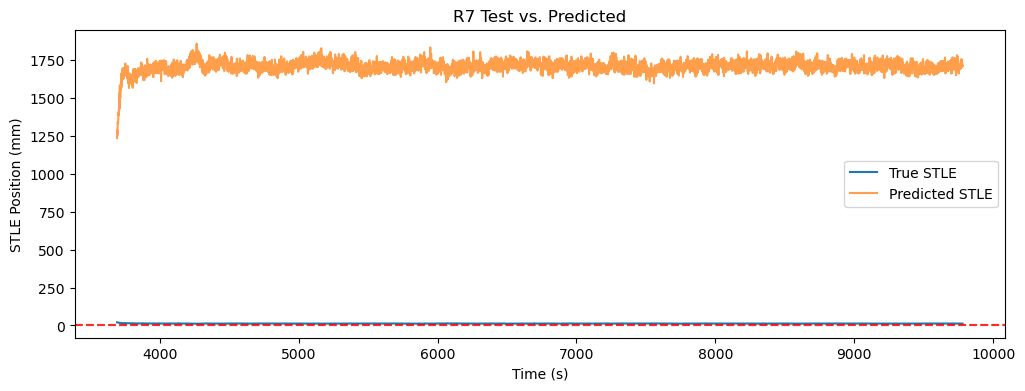

In [25]:
location_list_afit = ['px1','px2','px3','px4','px5']

for i in test_run_afit:
    result_subset = test_set_afit[test_set_afit['Run'] == i]
    plt.figure(figsize=(12,4))
    plt.plot(result_subset['x1'],label='True STLE')
    plt.plot(result_subset['pred'],label='Predicted STLE',alpha=0.75)
    plt.xlabel('Time (s)')
    plt.ylabel('STLE Position (mm)')
    plt.legend()
    for j in location_list_afit:
        plt.axhline(y=afit[afit['Run']==i][j].iloc[0], color='red', linestyle='--',alpha=0.3)
        
    plt.title(f"{i}" + ' Test vs. Predicted')
    plt.show()

Obvious results. Now let's train on AFIT only, and predict AFIT.

---

In [49]:
X_afit,y_afit,afit_df = aggregate_features_afit(afit)

X_afit['Run'] = afit_df['Run']
X_afit['x1'] = y_afit

train_run_afit = ['R8']
test_run_afit = ['R6','R7']

train_set_afit = X_afit[X_afit['Run'].isin(train_run_afit)]
test_set_afit = X_afit[X_afit['Run'].isin(test_run_afit)]
df_train_afit = afit_df[afit_df['Run'].isin(train_run_afit)]
df_test_afit = afit_df[afit_df['Run'].isin(test_run_afit)]

train_set_afit['H'] = 63.5
train_set_afit['W'] = 63.5
test_set_afit['H'] = 63.5
test_set_afit['W'] = 63.5

X_train_afit = train_set_afit.drop(['Run','x1'],axis=1)
X_test_afit = test_set_afit.drop(['Run','x1'],axis=1)
y_train_afit = train_set_afit['x1']
y_test_afit = test_set_afit['x1']

In [51]:
def RunNeuralNet(train_df, test_df):
    X_train = train_df.drop(['x1','Run','H','W'],axis=1)
    X_test = test_df.drop(['x1','Run','H','W'],axis=1)
    y_train = train_df['x1']
    y_test = test_df['x1']
    
    model = Sequential()
    
    model.add(Dense(20, activation='relu'))

    model.add(Dense(1))
    
    initial_lr = 0.0015
    model.compile(optimizer='adam',loss='mae')
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=30, mode='min', verbose=1)
    
    model.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=500,callbacks=[early_stopping])
    
    y_pred = model.predict(X_test)
    test_df = test_df.copy()
    test_df['pred'] = y_pred
    
    return test_df,model

In [52]:
result, model = RunNeuralNet(train_set_afit, test_set_afit)

Epoch 1/500
47/47 [==============================] - 0s 2ms/step - loss: 16.0718 - val_loss: 4.0416
Epoch 2/500
47/47 [==============================] - 0s 1ms/step - loss: 11.9925 - val_loss: 5.2057
Epoch 3/500
47/47 [==============================] - 0s 1ms/step - loss: 7.9388 - val_loss: 8.3853
Epoch 4/500
47/47 [==============================] - 0s 1ms/step - loss: 3.1904 - val_loss: 16.4781
Epoch 5/500
47/47 [==============================] - 0s 1ms/step - loss: 0.4629 - val_loss: 16.8900
Epoch 6/500
47/47 [==============================] - 0s 1ms/step - loss: 0.4314 - val_loss: 16.8763
Epoch 7/500
47/47 [==============================] - 0s 1ms/step - loss: 0.4299 - val_loss: 16.8871
Epoch 8/500
47/47 [==============================] - 0s 1ms/step - loss: 0.4287 - val_loss: 16.8149
Epoch 9/500
47/47 [==============================] - 0s 1ms/step - loss: 0.4272 - val_loss: 16.7992
Epoch 10/500
47/47 [==============================] - 0s 1ms/step - loss: 0.4261 - val_loss: 16.8403


In [56]:
X_test_afit = X_test_afit.drop(['H','W'],axis=1)
y_pred_afit = model.predict(X_test_afit)

409/409 [==============================] - 0s 244us/step


In [57]:
test_set_afit['pred'] = y_pred_afit

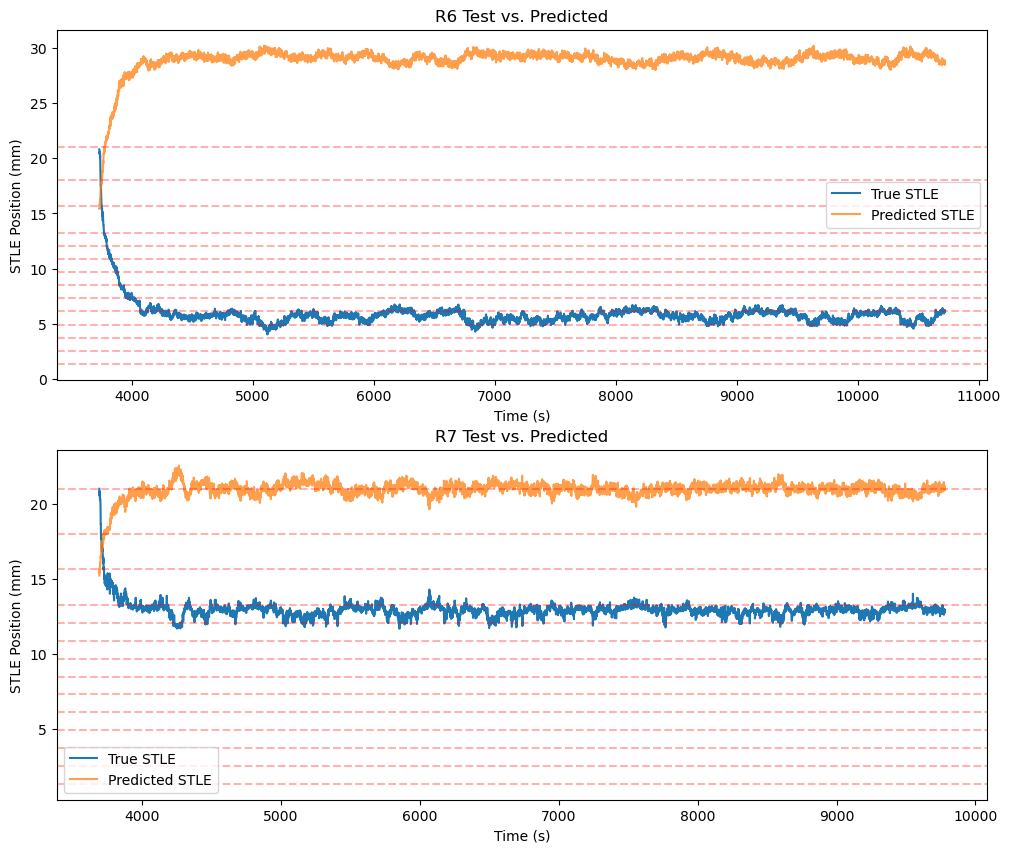

In [58]:
location_list_afit = ['px1', 'px2', 'px3', 'px4', 'px5', 'px6', 'px7', 'px8', 'px9', 'px10',
       'px11', 'px12', 'px13', 'px14']

fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(12,10))

j = 0

for i in test_run_afit:
    result_subset = test_set_afit[test_set_afit['Run'] == i]
    axes[j].plot(result_subset['x1'],label='True STLE')
    axes[j].plot(result_subset['pred'],label='Predicted STLE',alpha=0.75)
    axes[j].set_xlabel('Time (s)')
    axes[j].set_ylabel('STLE Position (mm)')
    axes[j].legend()
    for k in location_list_afit:
         axes[j].axhline(y=afit[afit['Run']==i][k].iloc[0], color='red', linestyle='--',alpha=0.3)
    axes[j].set_title(f"{i}" + ' Test vs. Predicted')
    j += 1
plt.show()

In [ ]:
model.save('../code/afit_model_a')

---

## Both results show bad performance when predicting the AFIT data. This shows that the transfer learning method is reasonably working. 

In [99]:
from keras import regularizers
from tensorflow.keras.layers import Dropout

In [110]:
X_afit,y_afit,afit_df = aggregate_features_afit(afit)

X_afit['Run'] = afit_df['Run']
X_afit['x1'] = y_afit

train_run_afit = ['R8']
test_run_afit = ['R6','R7']

train_set_afit = X_afit[X_afit['Run'].isin(train_run_afit)]
test_set_afit = X_afit[X_afit['Run'].isin(test_run_afit)]
df_train_afit = afit_df[afit_df['Run'].isin(train_run_afit)]
df_test_afit = afit_df[afit_df['Run'].isin(test_run_afit)]

X_train_afit = train_set_afit.drop(['Run','x1'],axis=1)
X_train_afit_scaled = ss.transform(X_train_afit)
X_test_afit = test_set_afit.drop(['Run','x1'],axis=1)
X_test_afit_scaled = ss.transform(X_test_afit)
y_train_afit = train_set_afit['x1']
y_test_afit = test_set_afit['x1']

In [111]:
base_model = load_model('no_time_aggregated_model_umich_use_for_transfer_learning_jul5')

In [112]:
from tensorflow.keras.optimizers import Adam

In [113]:
initial_lr = 0.001
epochs_per_lr_decay = 10
lr_decay_factor = 0.1

def lr_schedule(epoch):
    return initial_lr * lr_decay_factor ** (epoch // epochs_per_lr_decay)

optimizer = Adam(learning_rate=initial_lr)

In [114]:
new_model = Sequential()

base_model.trainable = False
    
new_model.add(base_model)
new_model.add(Dense(20, activation='relu'))
new_model.add(Dense(1))
              
new_model.compile(optimizer=optimizer,loss='mse')

In [115]:
early_stopping = EarlyStopping(monitor='val_loss', patience=30, mode='min', verbose=1)

result = new_model.fit(x=X_train_afit_scaled,y=y_train_afit,
          validation_data=(X_test_afit_scaled,y_test_afit),
          batch_size=128,epochs=300, callbacks=[early_stopping])

Epoch 1/300
47/47 [==============================] - 0s 2ms/step - loss: 63.9635 - val_loss: 78.5935
Epoch 2/300
47/47 [==============================] - 0s 1ms/step - loss: 0.5888 - val_loss: 54.6765
Epoch 3/300
47/47 [==============================] - 0s 1ms/step - loss: 0.1436 - val_loss: 55.5689
Epoch 4/300
47/47 [==============================] - 0s 1ms/step - loss: 0.1419 - val_loss: 55.9513
Epoch 5/300
47/47 [==============================] - 0s 1ms/step - loss: 0.1420 - val_loss: 55.4948
Epoch 6/300
47/47 [==============================] - 0s 1ms/step - loss: 0.1418 - val_loss: 55.9178
Epoch 7/300
47/47 [==============================] - 0s 1ms/step - loss: 0.1421 - val_loss: 56.1629
Epoch 8/300
47/47 [==============================] - 0s 1ms/step - loss: 0.1424 - val_loss: 56.3208
Epoch 9/300
47/47 [==============================] - 0s 1ms/step - loss: 0.1423 - val_loss: 55.9683
Epoch 10/300
47/47 [==============================] - 0s 1ms/step - loss: 0.1423 - val_loss: 56.279

<Axes: >

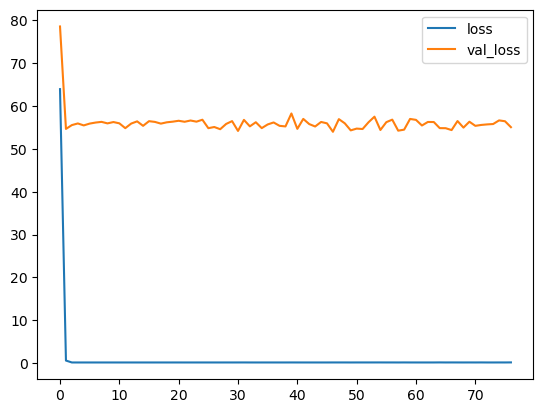

In [116]:
pd.DataFrame(result.history).plot()

In [117]:
y_pred = new_model.predict(X_test_afit)

409/409 [==============================] - 0s 280us/step


In [118]:
test_set_afit['pred'] = y_pred

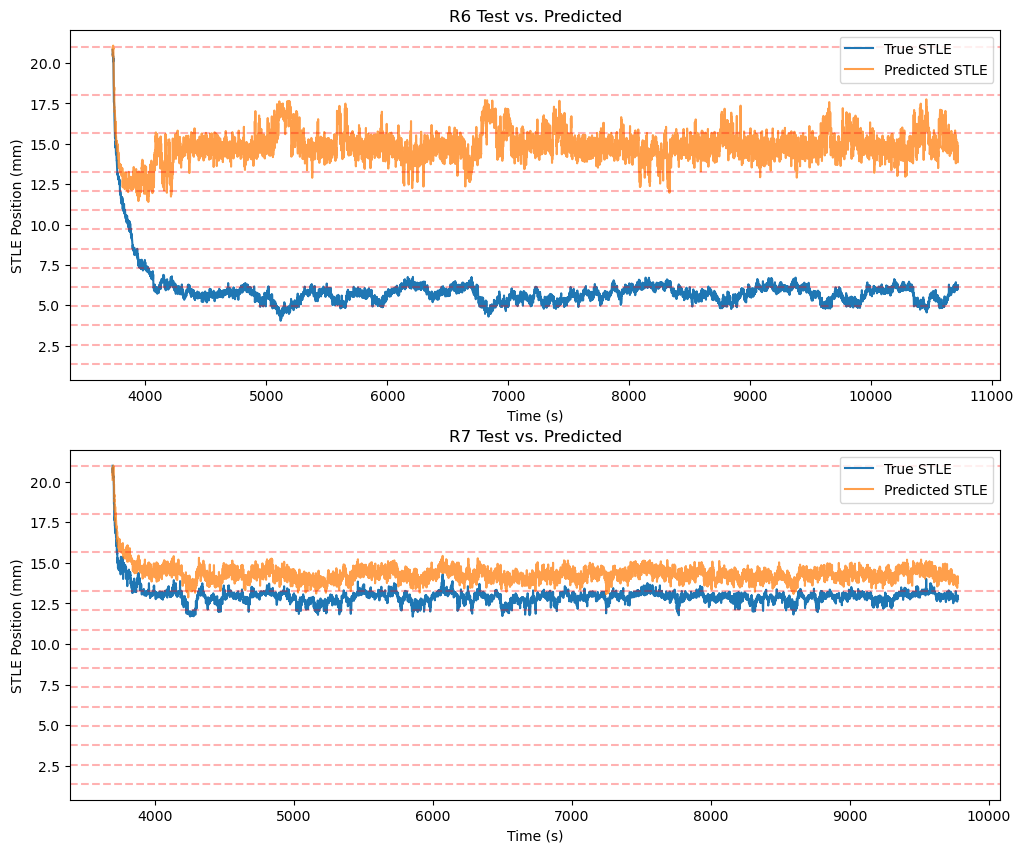

In [119]:
location_list_afit = ['px1', 'px2', 'px3', 'px4', 'px5', 'px6', 'px7', 'px8', 'px9', 'px10',
       'px11', 'px12', 'px13', 'px14']

fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(12,10))

j = 0

for i in test_run_afit:
    result_subset = test_set_afit[test_set_afit['Run'] == i]
    axes[j].plot(result_subset['x1'],label='True STLE')
    axes[j].plot(result_subset['pred'],label='Predicted STLE',alpha=0.75)
    axes[j].set_xlabel('Time (s)')
    axes[j].set_ylabel('STLE Position (mm)')
    axes[j].legend()
    for k in location_list_afit:
         axes[j].axhline(y=afit[afit['Run']==i][k].iloc[0], color='red', linestyle='--',alpha=0.3)
    axes[j].set_title(f"{i}" + ' Test vs. Predicted')
    j += 1
    
plt.savefig('figures/AFIT/transferred_figures/R6R7_predict.png')
plt.show()